# How to use PyNNDescent

PyNNDescent is a library that provides fast approximate nearest neighbor search. It is designed to be as flexible as possible for python users. That includes a wealth of pre-defined distance measures, the ability to use custom user-defined distance measures, as well as handling of sparse matrix inputs and more. Let's walk through how you can use PyNNDescent for approximate nearest neighbor search. First let's load the library, and some tools to get some suitable data.

In [1]:
import pynndescent
import numpy as np
import h5py
from urllib.request import urlretrieve
import os

The [ann-benchmarks](http://ann-benchmarks.com) website, maintained by Erik Bernhardsson, Martin Aumueller and Alex Faitfull, provides a comprehensive suite of benchmarking for approximate nearest neighbor libraries and algorithms. For our purposes the important fact is that this includes keeping a variety of datasets, of varying levels of size and difficulty, for trying out nearest neighbor search on. To make things easy we'll write a short function that can fetch the (pre-prepared) dataset from ann-benchmarks and load it into train and test numpy arrays.

In [2]:
def get_ann_benchmark_data(dataset_name):
    if not os.path.exists(f"{dataset_name}.hdf5"):
        print(f"Dataset {dataset_name} is not cached; downloading now ...")
        urlretrieve(f"http://ann-benchmarks.com/{dataset_name}.hdf5", f"{dataset_name}.hdf5")
    hdf5_file = h5py.File(f"{dataset_name}.hdf5", "r")
    return np.array(hdf5_file['train']), np.array(hdf5_file['test']), hdf5_file.attrs['distance']

To start let's grab the [fashion-mnist](https://github.com/azlandoresearch/fashion-mnist) dataset for some initial experiments.

In [3]:
fmnist_train, fmnist_test, _ = get_ann_benchmark_data('fashion-mnist-784-euclidean')

With the dataset now loaded let's build a search index for the training set. This is done using the ``NNDescent`` class, which we simply hand the training data to (we'll look at other parameter options later). It will take a little time to build the index, so let's keep track using the ``%time`` magic in jupyter.

In [4]:
%%time
index = pynndescent.NNDescent(fmnist_train)

CPU times: user 48.5 s, sys: 1.07 s, total: 49.5 s
Wall time: 27.7 s


Over ten seconds! That seems slow. How much data did we index, and how high dimensional is it?

In [5]:
fmnist_train.shape

(60000, 784)

Okay, so sixty-thousand samples living in a seven-hundred and eighty-four dimensional space -- that is a reasonable amount of data. We already had the data however, so why did we spend all that time building an index on top of it? It allows us to query that data to find the points closest to new, previously unseen data points. This is a surprisingly common problem -- "find the other things that look like this" -- that crops up in everything from recommendation systems (e.g. what are some other songs or artists that are like this song?), to classification and regression (using a [KNN-classifier](https://scikit-learn.org/stable/modules/neighbors.html#classification) and friends), to clustering (and density based clustering algorithm makes heavy use of near neighbor searches to determine density).

So, given that we have built an index on the training data, we can use that index to find the nearest neighbors from the training set to each sample in the test set. Let's do that now for the first 10 samples of the test set, again, keeping track of the time:

In [6]:
%%time
neighbors = index.query(fmnist_test[:10])

CPU times: user 23.4 s, sys: 377 ms, total: 23.8 s
Wall time: 18.3 s


That was also slow! What happened? The first time the index is queried it does some book-keeping (that may not be required for some other tasks as we'll see below). There is also time for numba to JIT compile many routines in the background (you might find, for instance, that the very first run of index building might take longer than you expect, but subsequence runs are much faster). You can force this ahead of time by calling the ``prepare`` method. Let's rebuild the index from scratch including the ``prepare`` step to see how long that takes.

In [7]:
%%time
index = pynndescent.NNDescent(fmnist_train)
index.prepare()

CPU times: user 47.3 s, sys: 743 ms, total: 48.1 s
Wall time: 20 s


That took longer, but how long do the queries take now? Let's query the entire test set.

In [8]:
%%time
neighbors = index.query(fmnist_test)

CPU times: user 742 ms, sys: 17.6 ms, total: 759 ms
Wall time: 758 ms


That's more like the sort of performance we might have been hoping for. And just to demonstrate that the prepare step is getting called on the first query, we'll start from scratch again.

In [9]:
%%time
index = pynndescent.NNDescent(fmnist_train)
neighbors = index.query(fmnist_test[:10])

CPU times: user 47.1 s, sys: 673 ms, total: 47.8 s
Wall time: 19.4 s


In [10]:
%%time
neighbors = index.query(fmnist_test)

CPU times: user 785 ms, sys: 21.3 ms, total: 806 ms
Wall time: 821 ms


Again, we get the sort of performance we might hope for by constructing a fast index over the data (and the numba JIT compiler is stating to warm up a little). There is a catch however -- at the start we said **approximate** nearest neighbor search. We might have gotten some neighbors data returned, but how good is it? Being fast doesn't matter if you return random results. To check we'll have to find the true nearest neighbors of the test set. Given that we have to search through sixty-thousand points for each of the ten-thousand test samples a pure brute force approach is going to be too expensive. Instead we can use [kd-trees](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KDTree.html) from scikit-learn.

In [11]:
from sklearn.neighbors import KDTree

The ``KDTree`` is scikit-learn has a very similar interface. You hand the tree constructor the training data, and then you can query it. In this case there is no prepare step required -- all the work is done at construction time since there aren't intermediate results that might be useful. We can time how long the ``KDTree`` takes to do its exact nearest neighbor computation to get a gauge on what PyNNDescent is buying us before we get to the issue of comparing the results of the exact and approximate algorithms.

In [12]:
%%time
tree_index = KDTree(fmnist_train)

CPU times: user 15.2 s, sys: 177 ms, total: 15.3 s
Wall time: 15.6 s


A faster build time for the tree itself. The question is how well the tree index works when querying new points...

In [13]:
%%time
tree_neighbors = tree_index.query(fmnist_test, k=10)

CPU times: user 10min 19s, sys: 3.24 s, total: 10min 22s
Wall time: 11min 12s


Ouch! We can see now what PyNNDescent is buying us in terms of querying speed (though, to be fair, this is high dimensional data that is a worst case scenario for kd-trees). We did have to give up some accuracy to get that speed-up however. The real question is how much accuracy did we lose? How approximate are our nearest neighbors?

We can write a short function to take some approximate neighbors and the true neighbors and output the proportion of neighbors that the apprxomation got correct for each and every query point (i.e. each point of the test set).

In [14]:
def accuracy_per_query_point(approx_neighbors, true_neighbors):
    approx_indices = approx_neighbors[0]
    true_indices = true_neighbors[1]
    result = np.zeros(approx_indices.shape[0])
    for i in range(approx_indices.shape[0]):
        n_correct = np.intersect1d(approx_indices[i], true_indices[i]).shape[0]
        result[i] = n_correct / true_indices.shape[1]
    return result

In [15]:
accuracy_stats = accuracy_per_query_point(neighbors, tree_neighbors)

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={"figure.figsize":(10,6)})

Average accuracy of 0.9781


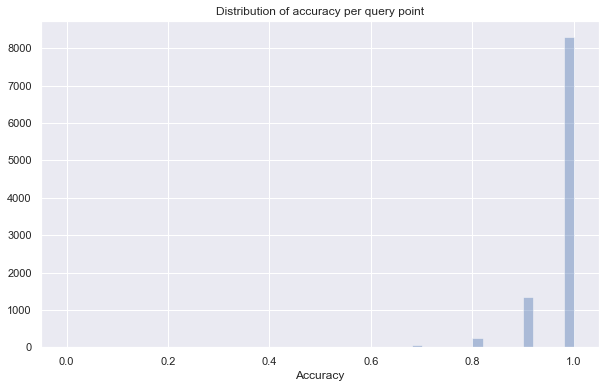

In [17]:
sns.distplot(accuracy_stats, kde=False)
plt.title("Distribution of accuracy per query point")
plt.xlabel("Accuracy")
print(f"Average accuracy of {np.mean(accuracy_stats)}")

So we are getting 100% accuracy for the vast majority of query points, but there are a thousand or so that get one neighbor wrong, and a very few that get two or three wrong. Even then we are likely getting the eleventh and twelfth nearest neighbors in those cases. So in general we have a very high accuracy given how much faster the query is.

## Query parameters

What if we want to be more accurate? There are a few ways to go about this. The most obvious is to simply ask for more neighbors, and then the top 10 will be more accurate. We can do this by specifying ``k`` in the query (just as we did for the KDTree -- it is just that PyNNDescent defaults to 10 neighbors).

In [18]:
%%time
more_neighbors = index.query(fmnist_test, k=15)

CPU times: user 1.1 s, sys: 486 ms, total: 1.59 s
Wall time: 1.99 s


Average accuracy of 0.99021


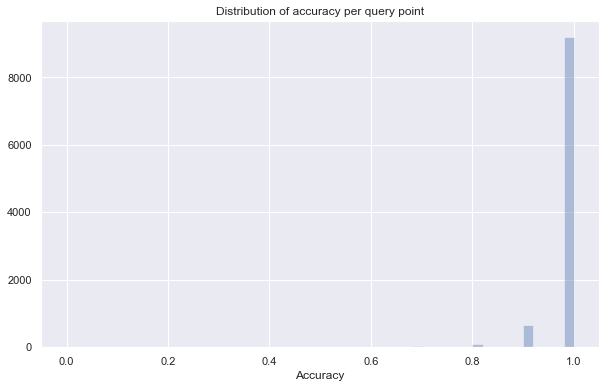

In [19]:
more_accuracy_stats = accuracy_per_query_point(more_neighbors, tree_neighbors)
sns.distplot(more_accuracy_stats, kde=False)
plt.title("Distribution of accuracy per query point")
plt.xlabel("Accuracy")
print(f"Average accuracy of {np.mean(more_accuracy_stats)}")

An alternative approach is to tolerate a little more backtracking in the approximate search. This is controlled by the parameter ``epsilon``. The larger the value the more backtracking the algorithm will tolerate, and the more accurate it will be (at the cost of greater search time). The default value is ``0.1`` and for euclidean distance going to ``0.2`` or even ``0.3`` might make sense. You can, of course, also turn it down to ``0.0`` and do *no* backtracking for even faster search (but reduced accuracy). Let's try both options; greater accuracy first.

In [20]:
%%time
better_neighbors = index.query(fmnist_test, epsilon=0.2)

CPU times: user 1.35 s, sys: 18.2 ms, total: 1.37 s
Wall time: 1.39 s


Average accuracy of 0.9965


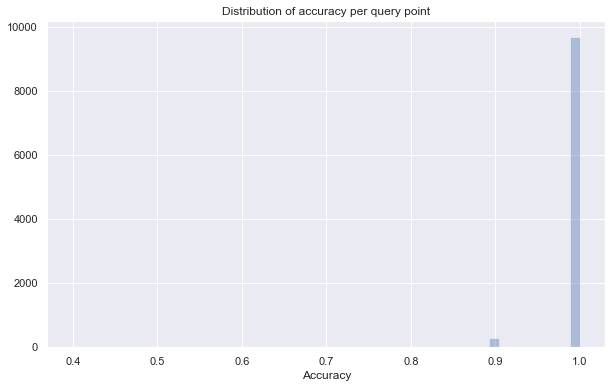

In [21]:
better_accuracy_stats = accuracy_per_query_point(better_neighbors, tree_neighbors)
sns.distplot(better_accuracy_stats, kde=False)
plt.title("Distribution of accuracy per query point")
plt.xlabel("Accuracy")
print(f"Average accuracy of {np.mean(better_accuracy_stats)}")

With ``epsilon=0.2`` we see a great improvement in accuracy. Everything but a very small number of query points get all 10 neighbors correct! We took a little more time, but still vastly less than the kd-tree. We also were significantly more accurate than simply taking more neighbors for very little extra cost in search time. What if we go the other way and turn ``epsilon`` down to zero?

In [22]:
%%time
worse_neighbors = index.query(fmnist_test, epsilon=0.0)

CPU times: user 456 ms, sys: 6.8 ms, total: 462 ms
Wall time: 471 ms


Average accuracy of 0.88776


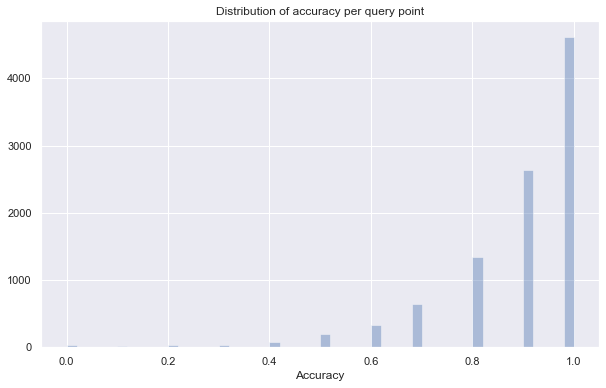

In [23]:
worse_accuracy_stats = accuracy_per_query_point(worse_neighbors, tree_neighbors)
sns.distplot(worse_accuracy_stats, kde=False)
plt.title("Distribution of accuracy per query point")
plt.xlabel("Accuracy")
print(f"Average accuracy of {np.mean(worse_accuracy_stats)}")

The accuracy has dropped quite a bit now, but if we only need to be "close" then this might be good enough, and it is definitely faster. This provides an easy trade-off between accuracy and query time.

## Index parameters

It is often the case that we know what we really need is fast queries -- as fast as possible -- and we are willing to sacrifice accuracy to get there. We know we are going to do a lot of queries, so it would be better if we could set up the index itself to target faster querying rather than just hoping the ``epsilon`` parameter will get things fast enough.

Alternatively we might really want very accurate queries -- ideally exact queries, but they are too expensive -- and be prepared to put in more work on the index to make queries more accurate but still fast.

These options can be dealt with via various parameters that are passed to the index constructor. There are many parameters that can be tweaked (check the docstring for full details), but in practice there are only a few we need to concern ourselves with. The primary ones of interest are

 1. ``n_neighbors``;
 2. ``diversify_prob``; and
 3. ``pruning_degree_multiplier``.
 
We'll look at each in turn to get a quick understanding of what they do. First up is ``n_neighbors``. By default this is ``30``; more neighbors leads to a more accurate (albeit slower) index, fewer neighbors leads to a faster index at the cost of accuracy. In general for a high accuracy (on the order or 90%+) index you might want an ``n_neighbors`` value in the range of fifty to one-hundred (a lot will depend on other issues, such as the dataset itself, and the metric used -- angular metrics generally need higher ``n_neighbors`` values). For fast indexes you can set it more in the range of five to twenty (again, dependent on the dataset itself and the metric; a little experimentation may be required). Let's try a couple of values with the fashion-mnist dataset and see how it works.

In [24]:
%%time
accurate_index = pynndescent.NNDescent(fmnist_train, n_neighbors=50)
accurate_index.prepare()

CPU times: user 1min 21s, sys: 1.77 s, total: 1min 23s
Wall time: 35.1 s


It takes a little longer to construct the index. Querying will also be a little slower.

In [25]:
%%time
accurate_neighbors = accurate_index.query(fmnist_test, epsilon=0.2)

CPU times: user 1.39 s, sys: 20.2 ms, total: 1.41 s
Wall time: 1.42 s


Average accuracy of 0.9980899999999999


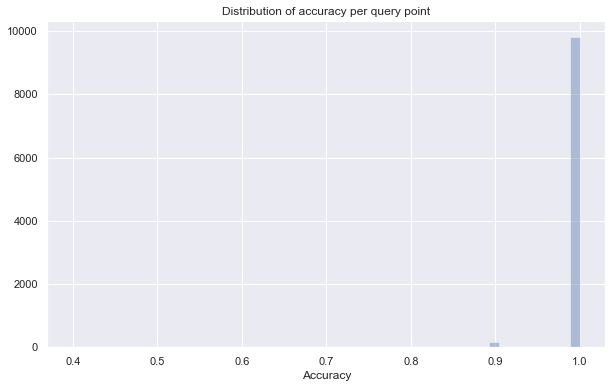

In [26]:
acc_index_accuracy_stats = accuracy_per_query_point(accurate_neighbors, tree_neighbors)
sns.distplot(acc_index_accuracy_stats, kde=False)
plt.title("Distribution of accuracy per query point")
plt.xlabel("Accuracy")
print(f"Average accuracy of {np.mean(acc_index_accuracy_stats)}")

But we see that we are now essentially just about perfect with our accuracy -- only a few query points have any neighbors at all that aren't true nearest neighbors (and they are almost certainly very close).

Now we can go the other way, and try to make a very very fast index (supposing we want to make an awful lot of queries at a very high throughput rate). We can decrease ``n_neighbors``.

In [27]:
%%time
fast_index = pynndescent.NNDescent(fmnist_train, n_neighbors=5)
fast_index.prepare()

/Users/leland/anaconda3/envs/numba51/lib/python3.8/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


CPU times: user 23.5 s, sys: 974 ms, total: 24.5 s
Wall time: 9.15 s


In [28]:
%%time
fast_neighbors = fast_index.query(fmnist_test, epsilon=0.0)

CPU times: user 290 ms, sys: 13.8 ms, total: 304 ms
Wall time: 305 ms


Average accuracy of 0.6279


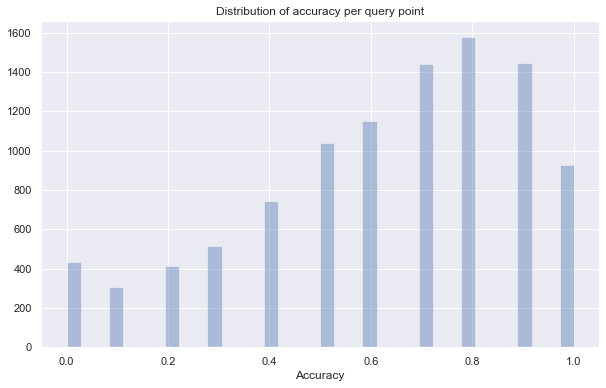

In [29]:
fast_index_accuracy_stats = accuracy_per_query_point(fast_neighbors, tree_neighbors)
sns.distplot(fast_index_accuracy_stats, kde=False)
plt.title("Distribution of accuracy per query point")
plt.xlabel("Accuracy")
print(f"Average accuracy of {np.mean(fast_index_accuracy_stats)}")

The results are not that accurate -- there are some query points that got no neighbors right (although it likely still got close-by points). However is speed is of the essence we have gotten under the time we were previously capable of with an ``epsilon`` of ``0.0``. Depending on your needs, and the nature of your dataset you can play with ``n_neighbors`` to find the trade-off between speed and accuracy that best suits you.

The next step is ``diversify_prob``. When PyNNDescent is constructing it's graph based index it tries to "diversify" the edges, pruning away some that are largely redundant. The value of ``diversify_prob`` is the probability that an edge identified as redundant will get pruned. The more edges that get pruned away the less accurate the index is, but with fewer edges searching becomes much faster. If you want as accurate an index as you can get then turn ``diversify_prob`` to ``0.0``. For speed you should obviously use ``1.0`` and prune away as many edges as you can. The default value is, in fact, ``1.0`` since it is usually worth it to edges identified by the diversify step. Let's try setting it to ``0.0`` and see how that effects speed and accuracy.

In [30]:
%%time
accurate_index = pynndescent.NNDescent(fmnist_train, n_neighbors=50, diversify_prob=0.0)
accurate_index.prepare()

CPU times: user 1min 47s, sys: 1.07 s, total: 1min 48s
Wall time: 40.6 s


In [31]:
%%time
accurate_neighbors = accurate_index.query(fmnist_test, epsilon=0.2)

CPU times: user 3.04 s, sys: 37.6 ms, total: 3.07 s
Wall time: 3.12 s


Average accuracy of 0.9999299999999999


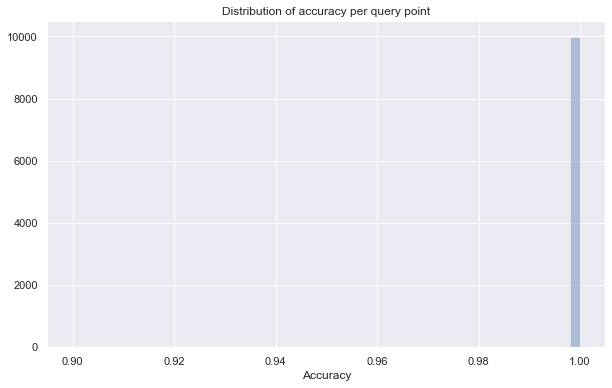

In [32]:
acc_index_accuracy_stats = accuracy_per_query_point(accurate_neighbors, tree_neighbors)
sns.distplot(acc_index_accuracy_stats, kde=False)
plt.title("Distribution of accuracy per query point")
plt.xlabel("Accuracy")
print(f"Average accuracy of {np.mean(acc_index_accuracy_stats)}")

At this point out of ten-thousand query points, each with 10 neighbors, we are getting a grand total of eight wrong -- that's eight out of a hundred-thousand! Of course our query time is up to several seconds now, but that still beats the many minutes of the kd-trees by a wide margin.

We still have one parameter left however -- the ``pruning_degree_multplier``. This gives the multiple of the number of neighbors many edges that any given vertex in the search graph is allowed to have. So if ``n_neighbors`` is 30 and the ``pruning_degree_multiplier`` is the default ``1.5`` then any vertex in the graph can have at most forty-five edges connected to it. This prevents hubs (which form in high dimensional spaces) causing the search stage to blow out in complexity. It can be tuned, however, to trade off between speed and accuracy. Higher multiples result in more accurate graphs with more edges that take longer to search. Low multiples (including less than one!) result in graphs with many fewer edges that are fast to search, but may get stuck in local minima or fail to find the true nearest neighbors. Let's play with that dial for a moment...

In [33]:
%%time
accurate_index = pynndescent.NNDescent(
    fmnist_train, 
    n_neighbors=50, 
    diversify_prob=0.0, 
    pruning_degree_multiplier=3.0
)
accurate_index.prepare()

CPU times: user 1min 47s, sys: 1.35 s, total: 1min 48s
Wall time: 41.2 s


In [34]:
%%time
accurate_neighbors = accurate_index.query(fmnist_test, epsilon=0.2)

CPU times: user 3.65 s, sys: 69.9 ms, total: 3.72 s
Wall time: 3.71 s


Average accuracy of 1.0


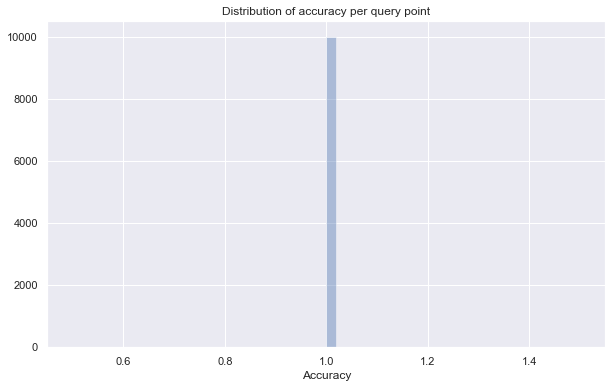

In [35]:
acc_index_accuracy_stats = accuracy_per_query_point(accurate_neighbors, tree_neighbors)
sns.distplot(acc_index_accuracy_stats, kde=False)
plt.title("Distribution of accuracy per query point")
plt.xlabel("Accuracy")
print(f"Average accuracy of {np.mean(acc_index_accuracy_stats)}")

By turning up the ``pruning_degree_multiplier`` we have achieved perfect accuracy -- and still at a very tiny fraction of the query time required for the exact kd-tree query. Of course on a different more complex dataset these same settings may not suffice. Ultimately what we lose is the *guarantee* that we will get the true nearest neighbors.

We can turn the dial the other way, however, and get very fast searching that is potentially still fairly accurate (compared to the very low ``n_neighbors`` version).

In [36]:
%%time
fast_index = pynndescent.NNDescent(
    fmnist_train, 
    n_neighbors=10, 
    diversify_prob=1.0,
    pruning_degree_multiplier=0.5,
)
fast_index.prepare()

/Users/leland/anaconda3/envs/numba51/lib/python3.8/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


CPU times: user 27.2 s, sys: 1.14 s, total: 28.3 s
Wall time: 11.3 s


In [37]:
%%time
fast_neighbors = fast_index.query(fmnist_test, epsilon=0.0)

CPU times: user 302 ms, sys: 16 ms, total: 318 ms
Wall time: 317 ms


Average accuracy of 0.65031


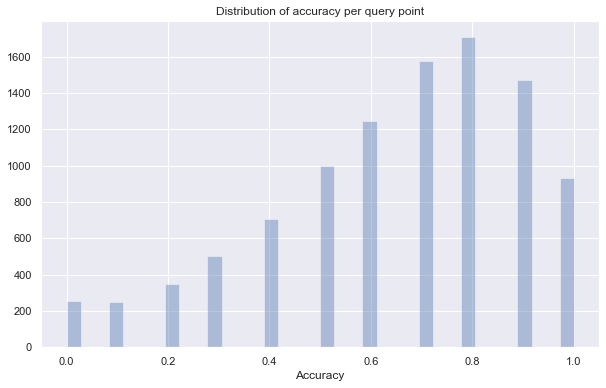

In [38]:
fast_index_accuracy_stats = accuracy_per_query_point(fast_neighbors, tree_neighbors)
sns.distplot(fast_index_accuracy_stats, kde=False)
plt.title("Distribution of accuracy per query point")
plt.xlabel("Accuracy")
print(f"Average accuracy of {np.mean(fast_index_accuracy_stats)}")

In general this isn't a good idea, but it gives you an idea of the trade-offs that can be made.

## Nearest neighbors of the training set

While querying for nearest neighbors of new points is a common use case, for many tasks, such as manifold learning or density based clustering, you want the nearest neighbors of all the points in the training set. You could build the index and then query for all the training points -- but because PyNNDescent builds a nearest neighbor graph as part of its index you can actually get there faster by just building the index and extracting the results directly. This is, for example, what libraries like [UMAP](https://github.com/lmcinnes/umap) and [OpenTSNE](https://github.com/pavlin-policar/openTSNE) do.

This is why the ``prepare`` step is kept separate. It is extra overhead, preparing the index to be queried for new unseen data, that isn't required for the use case of simply extracting the nearest neighbors of the full training set. Thus if we just build, but don't prepare, the index:

In [39]:
%%time
index = pynndescent.NNDescent(fmnist_train)

CPU times: user 36.5 s, sys: 375 ms, total: 36.9 s
Wall time: 14.8 s


We can then extract the nearest neighbors of each training sample by using the ``neighbor_graph`` attribute.

In [40]:
index.neighbor_graph

(array([[    0, 25719, 27655, ..., 38300,  4643,  7353],
        [    1, 42564, 37550, ..., 12169, 50358, 49552],
        [    2, 53513, 35424, ..., 16891, 29542, 40182],
        ...,
        [59997, 45348, 22272, ..., 58896, 53292, 11657],
        [59998, 17378,  8495, ...,  4389, 23426, 34912],
        [59999, 11912, 40600, ..., 31966, 45245, 58489]]),
 array([[   0.     , 1188.7826 , 1215.344  , ..., 1417.4388 , 1422.567  ,
         1424.7806 ],
        [   0.     , 1048.0482 , 1068.395  , ..., 1219.923  , 1222.1665 ,
         1225.5464 ],
        [   0.     ,  532.61993,  632.16534, ...,  885.45245,  886.3972 ,
          887.8125 ],
        ...,
        [   0.     , 1086.2596 , 1118.3738 , ..., 1303.3699 , 1306.9954 ,
         1308.5958 ],
        [   0.     ,  685.18243,  690.4209 , ...,  795.6589 ,  796.894  ,
          797.1349 ],
        [   0.     ,  884.41394,  886.4903 , ..., 1048.9224 , 1049.3502 ,
         1051.806  ]], dtype=float32))

The first array is ``n_samples`` by ``n_neighbors`` such that the ``i``th row contains the ``n_neighbors`` nearest neighbors of the ``i``th data point. The second array is the associated distances to each of those neighboring points. From the distance array you can see that each row is sorted, with the closest neighbors first, and the furthest last.

If you are simply wanting to extract this sort of data for further processing this is the fastest way to do it, and since you only need to run the index build and not actually query for any data, this can often be faster than some other approximate nearest neighbor techniques that need to be queried after being constructed.